# Evolving Ensembles in Multi-objective GeneticProgramming for Classification with Unbalanced Data

### Dataset YEAST

Minority class = 'MIT'

Majority class = other tags

-----------------------------------------

Imports

In [1]:
# Python 3.8.3
import deap # 1.3.1
from deap import gp, creator, base, tools, algorithms

import numpy as np # 1.18.5

import operator, random

import matplotlib.pyplot as plt

Defining Constants

In [2]:
PNUM = 20 # Number of individuals in a population
GNUM = 10 # Number of generations
MTC = 0.2 # Mutation chance

Helper functions for primitive operators

In [3]:
# Protected division
def div(x, y):
    if(y == 0):
        return 1
    else:
        return x/y

# If then operator
def if_then(a, b, c):
    if a < 0:
        return b
    else:
        return c

Helper functions for evaluation

In [4]:
# Evaluation function
def evaluateAccuracy(individual, data, names, pset): # po predlosku
    
    #Compiling the expression
    classificator = gp.compile(individual, pset)
    
    minority_count = names.count("MIT")
    true_positive_count = 0
    
    majority_count = len(names) - minority_count
    true_negative_count = 0
    
    for (d, n) in zip(data, names):
        # feeding data to individual classificator
        result = classificator(*d)
        
        #counting right answers
        if (n=="MIT") and (result >= 0): true_positive_count += 1
        elif (n!="MIT") and (result < 0): true_negative_count += 1

    # return accuracy on minority class and majority class
    return (true_positive_count/minority_count, true_negative_count/majority_count)

In [5]:
# Evaluation function that sets fitness values
def evaluatePopulation(population, data, names, pset):
    
    # Evaluating each individual in population
    for individual in population:
        
        # Compiling the expression
        classificator = gp.compile(individual, pset)

        minority_count = names.count("MIT")
        true_positive_count = 0

        majority_count = len(names) - minority_count
        true_negative_count = 0

        for (d, n) in zip(data, names):
            # Feeding data to individual classificator
            result = classificator(*d)

            # Counting right answers
            if (n=="MIT") and (result >= 0): true_positive_count += 1
            elif (n!="MIT") and (result < 0): true_negative_count += 1

        # Save fitness values for individual
        individual.fitness.values = (true_positive_count/minority_count, true_negative_count/majority_count)
    
#     return population

In [6]:
# Mating function, returns the combination of old population and new offspring
def crossoverPopulation(population):
    offspring = population.copy()
    
    while(len(population) > 1):
        (parent1, parent2) = random.sample(population, 2) # Chooses two random individuals from the population
        
        (child1, child2) = gp.cxOnePoint(parent1, parent2) # Crossover function, gives 2 new individuals
        
        population.remove(parent1)
        population.remove(parent2)
        
        offspring.append(child1)
        offspring.append(child2)
        
    # ZASAD: zadnji ostaje nemutiran ako je neparan broj populacije
    # ZA UBUDUCE: koristi drugi operator koji ce potencijalno dat razlicitu djecu
#     if(len(population) == 1)
    
    return offspring
        

In [7]:
# Mutating function
def mutatePopulation(population, pset, mutch):
    
    for individual in population:
        
        rand = random.random()

        if(rand <= mutch):
            individual = gp.mutNodeReplacement(individual, pset) # Replaces one node with another operation from pset
        
    return population

## PITANJE: koji je mating je najbolje koristit tu? ima semantic koji vec i mutira djecu

Import dataset from external file

In [8]:
# Define a filename
filename = "./Datasets/yeast.data"

# Opening and reading the file
with open(filename) as f:
    content = f.read().splitlines()
    
data = [] # data for saving the features from file
names = [] # names of the protein classes
    
for line in content:
    tmp = line.split()
    tmp.pop(0) # pops the first element - we dont need it
    
    names.append(tmp.pop()) # pops the last element - name of protein
    
    data.append(np.asarray(tmp, float)) # extracting features to data as float values

# testing data
# for d in data:
#     print(d)

Creating a primiive set for the classificator expression

In [9]:
# Creating a primitive set
pset = gp.PrimitiveSet("main", arity=8)

# Adding primitive operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div, 2) 
pset.addPrimitive(if_then, 3)

# Generate an expression where each leaf has the same depth between min and max.
# expr = gp.genFull(pset, min_=1, max_=8) # Create expression of max depth 8 (from paper)
# tree = gp.PrimitiveTree(expr) # Create tree classificator from expression

Creating a fitness function and an individual

In [10]:
# Create a multi objective fitness function with weights between objectives
creator.create("Fitness", base.Fitness, weights=(1.0, 1.0))

# Create an individual of type primitive tree and our fitness function, pset is a previously defined
creator.create("IndividualTree", gp.PrimitiveTree, fitness=creator.Fitness, pset=pset)


Registering elements

In [11]:
# Creating toolbox
toolbox = base.Toolbox()

# Register the type of expression the threes are gonna be with min and max depth (8 from paper)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=8) # genHalfAndHalf - Generate an expression with a PrimitiveSet pset. Half the time, the expression is generated with genGrow(), the other half, the expression is generated with genFull()
toolbox.register("individual", tools.initIterate, creator.IndividualTree, toolbox.expr) # Register individual from expression
# Register population of type bag
toolbox.register("population", tools.initRepeat, gp.PrimitiveTree, toolbox.individual)

# Operator functions

# Register evaluation function
toolbox.register('evaluatePop', evaluatePopulation, pset=pset)
# toolbox.register('evaluate', evaluateAccuracy, data=data, names=names, pset=pset) # po predlosku

# Register selection function
toolbox.register('select', tools.selSPEA2)

# Register mate function
toolbox.register('mate', crossoverPopulation)
# toolbox.register('mate', gp.cxOnePoint) # po predlosku

#Register mutate function
toolbox.register('mutate', mutatePopulation, pset = pset, mutch = MTC)
# toolbox.register('mutate', gp.mutNodeReplacement, pset=pset) # po predlosku

## pitanje: koji mutator koristit?

Generating population

In [12]:
# Generating population of n individuals
population = toolbox.population(n=PNUM)

Evolving the population

In [13]:
# ---------- ovo ne radi jer Primitive tree type ne zeli bit slicean na taj nacin
# algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50)
# algorithms.eaMuPlusLambda(population, toolbox, mu=5, lambda_=5, cxpb=0.5, mutpb=0.2, ngen=2, stats=None, halloffame=None, verbose=__debug__)

In [14]:
# po predlosku
# # Evaluate population
# fitnesses = toolbox.map(toolbox.evaluate, population)

# # Mapping fitness values to individuals
# for (ind, fit) in zip(population, fitnesses):
#     ind.fitness.values = fit

Genetic algorithm

In [15]:
# testing
xvalues = []
yvalues = []

for gen in range(GNUM):
    
    # Mating the population
    population = toolbox.mate(population)

    
    # Mutating the population
    population = toolbox.mutate(population)

    # Evaluating the population
    toolbox.evaluatePop(population = population, data=data, names=names)

    # Selecting offspring
    population = toolbox.select(population, PNUM)


#     TESTING
    xfront = []
    yfront = []
    for p in population:
#         print(p) # Testing
#         print()
#         print(p.fitness.values)
        xvalues.append(p.fitness.values[0])
        yvalues.append(p.fitness.values[1])
        
        xfront.append(p.fitness.values[0])
        yfront.append(p.fitness.values[1])
#     print()
#     print()

## ne radi, pogledaj ea simple implementaciju

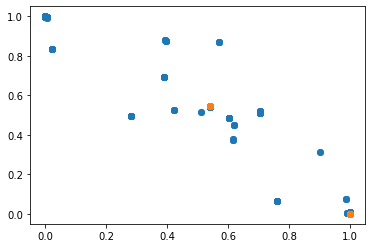

In [18]:
plt.plot(xvalues, yvalues, 'o')
plt.plot(xfront, yfront, 'o')
plt.show()